In [56]:
%run darcy_solver.ipynb

Exception: File `'darcy_solver.ipynb'` not found.

In [22]:
import os
os.chdir("..")
print(os.getcwd())

D:\repositories\PyFlowSolver


In [58]:
%run .\src\volumeManager.py
%run .\src\sparseArray.py
#VolumeManager

In [25]:
import porespy as ps

In [26]:
vol = ps.generators.blobs(shape=(100, 100, 100), porosity=0.35, seed=42)

In [27]:
import numpy as np
import scipy as sc

In [28]:
lab, n_lab = sc.ndimage.label(vol)

In [29]:
print(np.unique(lab[0,:,:]))
print(np.unique(lab[-1,:,:]))
print(np.unique(lab[:,0,:]))
print(np.unique(lab[:,-1,:]))
print(np.unique(lab[:,:,0]))
print(np.unique(lab[:,:,-1]))

[0 1 2 3]
[ 0  1 33 36 37 38]
[ 0  1  5 10 16 29 32 33]
[ 0  1  8 11 13 18 23 26]
[ 0  1  3  6  8 13 18 20 33]
[ 0  1 12 14 16]


In [30]:
con_vol = (lab==1)

In [31]:
con_vol.sum() / con_vol.size

0.344097

In [32]:
def get_unravel_function(volume, nulls_count):
    def unravel(x, y, z):
        w, h, d = volume.shape
        i = z + y * d + x * d * h
        try:
            output = i - nulls_count[i]
        except:
            print(x, y, z)
            raise
        return output
    return unravel

def sparse_matrix_extractor(volume):

    nonzeros = np.count_nonzero(volume)
    diag_nulls_count = np.empty(volume.size, dtype=int)
    running_zeros = 0
    i = 0
    w, h, d = volume.shape
    for x, y, z in ((a,b,c) for a in range(w) for b in range(h) for c in range(d)):
        center_c = volume[x, y, z]
        if center_c > 0:
            diag_nulls_count[i] = running_zeros
            i += 1
        else:
            running_zeros += 1
            diag_nulls_count[i] = running_zeros
            i += 1
    
    neighbour_displacement_template = np.array((h*d, d, 1), dtype=int)
    
    val_array = np.zeros(nonzeros * 7)
    col_idx_array = np.zeros(nonzeros * 7, dtype=int)
    row_ptr_array = np.zeros(nonzeros, dtype=int)
    condensed_b = np.zeros(nonzeros)
    
    sparse_i = 0
    vals_n = 0

    unravel = get_unravel_function(volume, diag_nulls_count)
    for x, y, z in ((a,b,c) for a in range(w) for b in range(h) for c in range(d)):
        coords = np.array((x, y, z))
        center_c = volume[tuple(coords)]

        if center_c == 0:
            continue

        x_min = (x == 0)
        x_max = (x == w - 1)
        y_min = (y == 0)
        y_max = (y == h - 1)
        z_min = (z == 0)
        z_max = (z == d - 1)

        key = (x_min, x_max, y_min, y_max, z_min, z_max)
        neighbours = neighbours_dict[key]

        total_c = np.float32(0)

        if z_min:
            total_c += 2 * center_c
            condensed_b[unravel(x, y, z)] = -(2 * center_c)
        elif z_max:
            total_c += 2 * center_c

        center_i = unravel(x, y, z)
        row_ptr_array[center_i] = vals_n
        for neighbour in neighbours:
            neighbour_c = volume[tuple(coords + neighbour)]
            if neighbour_c == 0: continue
            face_c = 2 / (1 / center_c + 1 / neighbour_c)
            total_c += np.float32(face_c)
            neighbour_displacement = (neighbour_displacement_template * neighbour)
            neighbour_i = unravel(*tuple(coords + neighbour))
            #A[i, i + neighbour_displacement] = face_c
            val_array[vals_n] = face_c
            col_idx_array[vals_n] = neighbour_i
            vals_n += 1
        #A[i,i] = - total_c
        val_array[vals_n] = face_c
        col_idx_array[vals_n] = neighbour_i
        vals_n += 1

        i += 1
    sparse_array = {
    "val": val_array,
    "col_idx": col_idx_array,
    "row_ptr": row_ptr_array,
    }
    return sparse_array, condensed_b
        
#sparse_array_large, condensed_b_large = sparse_matrix_extractor(con_vol)


In [33]:
sparse_array_1, condensed_b_1 = sparse_matrix_extractor(volume)

In [34]:
condensed_b_1

array([-2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,
        0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,
        0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.])

In [35]:
condensed_b

array([-2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,
        0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,
        0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.,
       -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.])

In [38]:
sparse_array_1["val"]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.33333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.33333333,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [39]:
sparse_array["val"]

array([-5.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -4.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -4.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -5.        ,  1.        ,  1.        ,  1.        , -6.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -4.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -5.33333349,  1.        ,  1.        ,  1.33333337,  1.        ,
        1.        , -6.        ,  1.        ,  1.        ,  1.        ,
       -6.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        , -4.        ,  1.        ,  1.        ,  1.        ,
        1.        , -5.33333349,  1.        ,  1.        ,  1.33333337,
        1.        ,  1.        , -6.        ,  1.        ,  1.        ,
        1.        , -5.        ,  1.        ,  1.        ,  1.        ,
        1.        , -4.        ,  1.        ,  1.        ,  1.  

In [40]:
volume_manager = VolumeManager(con_vol)

In [41]:
A, b = volume_manager.get_sparse_system()

In [42]:
A

In [43]:
b

array([-2.,  0.,  0., ...,  0.,  0.,  0.])

In [44]:
MAX_STEP = 1/4
STEP_ADJUSTMENT = 1/4
INITIAL_STEP = 1/8

X0 = np.linspace(0, 1, num=b.size, dtype=np.float32)
next_X = X0.copy
error = np.inf
step = INITIAL_STEP
residuals = calc_residuals(A, b, X0)

for i in range(1000):
    next_x = X0 - residuals * step
    next_residuals = calc_residuals(A, b, next_x)
    next_error = (next_residuals**2).sum()
    if next_error < error:
        residuals = next_residuals
        X0 = next_x
        error = next_error
        step += (MAX_STEP - step) * STEP_ADJUSTMENT
    else:
        step = 1/step
        step += (step - 1/MAX_STEP)
        step = 1/step
        
    print(i, next_error/X0.size, step)

AttributeError: 'NoneType' object has no attribute 'size'

In [8]:
vol_40 = ps.generators.blobs(shape=(25, 25, 25), porosity=0.38, seed=42)
lab_40, n_lab_40 = sc.ndimage.label(vol_40)
print(np.unique(lab_40[0,:,:]))
print(np.unique(lab_40[-1,:,:]))
print(np.unique(lab_40[:,0,:]))
print(np.unique(lab_40[:,-1,:]))
print(np.unique(lab_40[:,:,0]))
print(np.unique(lab_40[:,:,-1]))

[0 1 2 3 4 5 6]
[ 0  1 46 51 54 55 56 57 58 59 60 61]
[ 0  1 11 19 39 50 51 54]
[ 0  1  6 15 25 35 38 49]
[ 0  1  6 23 25 28 49 57 60]
[ 0  1  3  9 14 22 32 41 43 45 46 51]


In [29]:
con_vol_40 = (lab_40==1)
con_vol_40.sum() / con_vol_40.size

0.34003125

In [30]:
volume_manager_40 = VolumeManager(con_vol_40)
A_40, b_40 = volume_manager_40.get_sparse_system()

In [120]:
def get_diag_from_sparse(A_sparse):
    diag = np.zeros(A_sparse["row_ptr"].size, dtype=np.float32)
    def row_indexes_iterator():
        for start, stop in zip(A_sparse["row_ptr"][:-1], A_sparse["row_ptr"][1:]):
            yield start, stop
        else:
            yield A_sparse["row_ptr"][-1], A_sparse["val"].size

    for row, (start, stop) in enumerate(row_indexes_iterator()):
        for i in range(start, stop):
            col_idx = A_sparse["col_idx"][i]
            if col_idx == row:
                val = A_sparse["val"][i]
                diag[col_idx] = val

    return diag


In [145]:
MAX_STEP = 4
STEP_ADJUSTMENT = 1/12
INITIAL_STEP = 1/15

X0 = np.linspace(0.5, 0.5, num=b_40.size, dtype=np.float32)
next_X = X0.copy
error = np.inf
step = INITIAL_STEP
residuals = calc_residuals(A_40, b_40, X0)
diag = get_diag_from_sparse(A_40)

for i in range(4001):
    next_x = X0 - residuals * step / diag
    next_residuals = calc_residuals(A_40, b_40, next_x)
    next_error = (next_residuals**2).sum()
    if (next_error < error):# and (next_x >= 0).all():
        residuals = next_residuals
        X0 = next_x
        error = next_error
        step += (MAX_STEP - step) * STEP_ADJUSTMENT
    else:
        step = 1/step
        step += (step + 1/MAX_STEP)
        step = 1/step
        
    if i % 40 == 0:
        print(i, next_error/X0.size, next_error.max(), step, X0[np.array((0,26,618))], residuals[0], residuals[-1], residuals.max(), residuals.min())

0 0.04483372993563896 975.67163 0.3944444444444444 [0.51666665 0.51666665 0.51111114] 0.9611112 0.0 1.0022223 -1.0044444
40 3.5438445240858995e-05 0.77121145 1.216998409840424 [0.9959627 0.9977898 0.9863267] 0.0002657771 -0.0063230395 0.031628847 -0.03060025
80 1.1792104643678064e-05 0.25661978 1.2168750425729138 [0.9974272  0.9985984  0.99122703] 0.00011652708 -0.0033922493 0.019987166 -0.019717008
120 5.784056010507899e-06 0.12587263 1.2168750411190716 [0.9981714  0.99900573 0.99374557] 6.574392e-05 -0.0022567362 0.01372391 -0.012762204
160 3.3557415693278e-06 0.07302765 1.166413048478142 [0.99861896 0.9992503  0.99526536] 3.9815903e-05 -0.001658678 0.008842111 -0.008899525
200 2.2047821303279883e-06 0.04798047 0.9638660184369399 [0.9988975  0.99940246 0.99621314] 2.5629997e-05 -0.0013398081 0.0062958 -0.0067251623
240 1.5918606071061985e-06 0.03464207 0.9638636812483303 [0.9990731 0.9994982 0.9968111] 1.692772e-05 -0.0010518134 0.0054994226 -0.0054306984
280 1.2248181722124932e-06 0

In [128]:
A_40_dense, b_40_dense = volume_manager_40.get_linear_system()

In [129]:
solution = np.linalg.solve(A_40_dense, b_40_dense)

In [130]:
solution

array([0.99971735, 0.        , 0.        , ..., 0.06979606, 0.        ,
       0.        ], dtype=float32)

In [131]:
i = 0
w, h, d = con_vol_40.shape
pressure_field = np.zeros((w, h, d), dtype=np.float32)

for x, y, z in ((a,b,c) for a in range(w) for b in range(h) for c in range(d)):
    pressure_field[x,y,z] = solution[i]
    i += 1

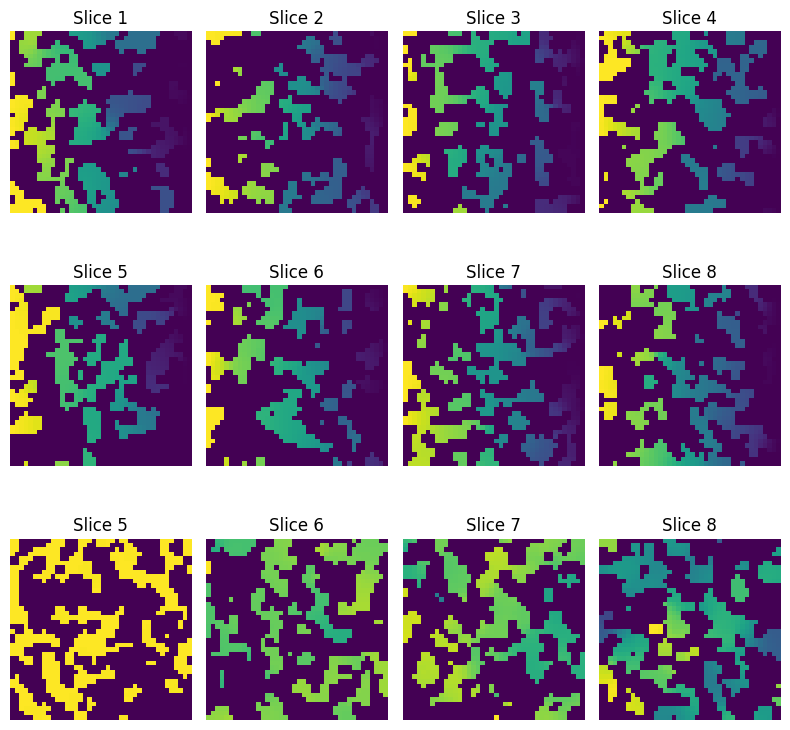

In [133]:
import matplotlib.pyplot as plt

num_slices = pressure_field.shape[2]
fig, axs = plt.subplots(3, 4, figsize=(8, 8))

for i in range(num_slices//10):
    slice_2d = pressure_field[i*10, :, :]
    axs[0,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[0,i].set_title(f'Slice {i + 1}')
    axs[0,i].axis('off')  # Turn off axis for better visualization

    slice_2d = pressure_field[:, i*10, :]
    axs[1,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[1,i].set_title(f'Slice {i + 1 + 4}')
    axs[1,i].axis('off')  # Turn off axis for better visualization

    slice_2d = pressure_field[:, :, i*10]
    axs[2,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[2,i].set_title(f'Slice {i + 1 + 4}')
    axs[2,i].axis('off')  # Turn off axis for better visualization

plt.tight_layout()
plt.show()

In [143]:
sparse_solution = -ravel_results(con_vol_40, X0)

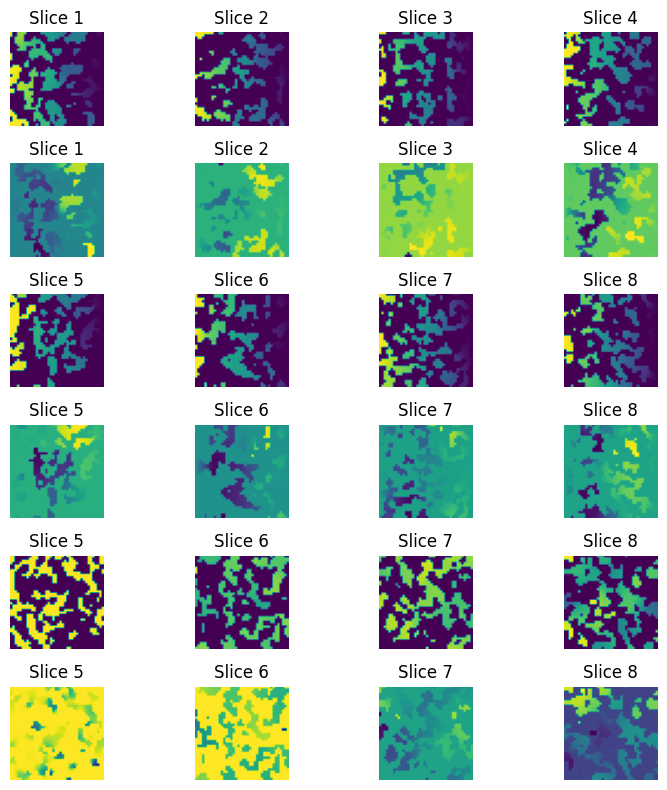

In [144]:
import matplotlib.pyplot as plt

num_slices = sparse_solution.shape[2]
fig, axs = plt.subplots(6, 4, figsize=(8, 8))

for i in range(num_slices//10):
    slice_2d = sparse_solution[i*10, :, :]
    axs[0,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[0,i].set_title(f'Slice {i + 1}')
    axs[0,i].axis('off')  # Turn off axis for better visualization

    slice_2d = sparse_solution[i*10, :, :] - pressure_field[i*10, :, :]
    axs[1,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[1,i].set_title(f'Slice {i + 1}')
    axs[1,i].axis('off')  # Turn off axis for better visualization

    slice_2d = sparse_solution[:, i*10, :]
    axs[2,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[2,i].set_title(f'Slice {i + 1 + 4}')
    axs[2,i].axis('off')  # Turn off axis for better visualization

    slice_2d = sparse_solution[:, i*10, :]  - pressure_field[:, i*10, :]
    axs[3,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[3,i].set_title(f'Slice {i + 1 + 4}')
    axs[3,i].axis('off')  # Turn off axis for better visualization

    slice_2d = sparse_solution[:, :, i*10]
    axs[4,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[4,i].set_title(f'Slice {i + 1 + 4}')
    axs[4,i].axis('off')  # Turn off axis for better visualization

    slice_2d = sparse_solution[:, :, i*10] - pressure_field[:, :, i*10]
    axs[5,i].imshow(slice_2d, cmap='viridis', origin='upper')
    axs[5,i].set_title(f'Slice {i + 1 + 4}')
    axs[5,i].axis('off')  # Turn off axis for better visualization

plt.tight_layout()
plt.show()

In [90]:
sparse_solution

array([[[-0.98765665,  0.        ,  0.        , ..., -0.03606764,
         -0.03155243,  0.        ],
        [-0.9930581 ,  0.        ,  0.        , ..., -0.03388643,
         -0.03077077,  0.        ],
        [ 0.        ,  0.        , -0.02166514, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        , -0.45915732, -0.37137008, ...,  0.        ,
          0.        ,  0.        ],
        [-0.8570465 , -0.5745727 , -0.4029677 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.86433333, -0.6110962 , -0.42420796, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.96005327, -0.85687345,  0.        , ..., -0.04250199,
          0.        ,  0.        ],
        [-0.98605716,  0.        ,  0.        , ..., -0.03808332,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        , -0.4510759 , -0.3651309 , ...,  

In [74]:
A_40['val'][:20]

array([-4.,  1.,  1., -3.,  1.,  1.,  1.,  1., -4.,  1.,  1.,  1.,  1.,
       -4.,  1.,  1.,  1.,  1., -2.,  1.])

In [75]:
A_40['col_idx'][:20]

array([  0,  26, 618,   1,   2,  27, 620,   1,   2,   3,  28, 621,   2,
         3,   4,  29, 622,   3,   4, 623])

In [77]:
A_40['row_ptr'][:6]

array([ 0,  3,  7, 12, 17, 20])

In [78]:
b_40[:20]

array([-2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [79]:
X0[:20]

array([-0.9848999 ,  0.02217583,  0.02207   ,  0.02141061,  0.02052934,
        0.04800538,  0.04714156,  0.04529136,  0.04247047,  0.03859088,
        0.03409007,  0.03301125,  0.03740627,  0.04296386,  0.04738953,
        0.05045765,  0.04118618,  0.03838046,  0.03459334,  0.03069892],
      dtype=float32)

In [80]:
X0[np.array((0,26,618))]

array([-0.9848999 , -0.99155056, -0.95072603], dtype=float32)

In [122]:
diag[:30]

array([-4., -3., -4., -4., -2., -2., -3., -4., -4., -4., -3., -3., -4.,
       -4., -4., -2., -3., -4., -4., -4., -4., -4., -1., -2., -4., -2.,
       -4., -4., -5., -4.], dtype=float32)

In [61]:
class DarcySolver():
    def __init__(self):
        self.default_params = {
            "max_step" : 4.,
            "step_adjustment" : 1/12,
            "initial_step" : 1/15,
            "max_iterations" : 100,
            "target_error" : 1e-07,
        }


    def solve(self, A, b, X0=None, **params):

        def param(key):
            return params.get(key, self.default_params[key])

        if X0 is None:
            X0 = np.linspace(1, 0, num=b.size, dtype=np.float32)
                
        next_x = X0.copy()
        error = np.inf
        step = param("initial_step")
        residuals = self.calc_residuals(A, b, X0)
        #diag = get_diag_from_sparse(A)
        diag = np.zeros(A.shape[0], dtype = np.float32)
        for i in range(A.shape[0]):
            diag[i] = A[i, i]

        for _ in range(param("max_iterations")):
            next_x = X0 - residuals * step / diag
            next_residuals = calc_residuals(A_40, b_40, next_x)
            next_error = (next_residuals**2).sum()
            if next_error <= param("target_error"):
                return next_x
            elif (next_error < error):# and (next_x >= 0).all():
                residuals = next_residuals
                X0 = next_x
                error = next_error
                step += (param("max_step") - step) * param("step_adjustment")
            else:
                step = 1/step
                step += (step + 1/param("max_step"))
                step = 1/step
            print(next_error/X0.size, next_error.max(), step, X0[np.array((0,26,618))], residuals[0], residuals[-1], residuals.max(), residuals.min())
        else:
            return X0


    def calc_residuals(self, sparse_array, condensed_b, X):

        residuals = np.zeros(condensed_b.size, dtype=np.float32)
        for row, start, stop in sparse_array.row_iterator():
            residual = np.float32(0)
            for index in range(start, stop):
                val = sparse_array[index]
                column = sparse_array.col_idx[index]
                x_val = X[column]
                residual += val * x_val
            residual -= condensed_b[row]
            residuals[row] = residual
        return residuals

In [47]:
import numpy as np
import scipy as sc
import porespy as ps

In [62]:
image = ps.generators.blobs(shape=(25, 25, 25), porosity=0.38, seed=42)
labeled_image, _ = sc.ndimage.label(image)
image = labeled_image == 1

volume_manager = VolumeManager(image)

dense_A, dense_b = volume_manager.get_linear_system()
solution_template = np.linalg.solve(dense_A, dense_b)
raveled_template = volume_manager.ravel_dense_solution(solution_template)

In [63]:
sparse_A, sparse_b = volume_manager.get_sparse_system()
solver = DarcySolver()
solution = solver.solve(sparse_A, sparse_b)
raveled_solution = volume_manager.ravel_sparse_solution(solution)
np.testing.assert_allclose(raveled_solution, raveled_template.val, rtol=1e-06)

UnboundLocalError: local variable 'start' referenced before assignment